#         CAPSTONE PROJECT - CLUSTERING OF CITIES OF THE WORLD

## Business Idea

The main objective of the project is to explore venue-based similarity between different cities of the world. So, that cities can be clustered as per similarity and can help the users to find similar cities for comfort of travelling or migrating.
Target Users:
1. people who wish to migrate to different cities and want similarity with respect to lifestyle venues.
2. travellers and tourists for places of their interests.

## Data

The cities data is obtained from the 'Simple Maps' Database, and 'FourSquare API' is used to explore the venues in each city. 
Each city will be explored by FourSquare data and features will be extracted and K-Means Algorithm will be applied.

Data source: https://simplemaps.com/data/world-cities

Features that will be extracted: 
1. City name
2. Country name
3. Latitude
4. Longitude
5. Venues in the city (by FourSquare API)
6. Category of the venue.

Hence, we will categorize or cluster the cities based on their similarity with respect to venue categories in its surrounding.

## Code

### import libraries

In [3]:
import numpy as np
import pandas as pd
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### read data

In [4]:
df = pd.read_csv('./worldcities.csv')
print('shape of df', df.shape)
df.head()

shape of df (15493, 11)


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


### Extract necessary columns and rows

In [6]:
df2 = df[df['population']>300000] # convert to 200000
cities_data = df2[['city', 'lat', 'lng', 'country']]
cities_data['city'] = cities_data['city'] + ', ' + cities_data['country']
cities_data.drop(['country'], axis=1, inplace=True)
cities_data.rename(columns={"city":"City"}, inplace=True)
print('shape of cities_data ', cities_data.shape)
cities_data.head()

shape of cities_data  (1502, 3)


,City,lat,lng
0,"Tokyo, Japan",35.6850,139.7514
1,"New York, United States",40.6943,-73.9249
2,"Mexico City, Mexico",19.4424,-99.1310
3,"Mumbai, India",19.0170,72.8570
4,"São Paulo, Brazil",-23.5587,-46.6250


### Foursquare Credentials

In [7]:

CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PPFUOF5NG2YIO1RH1EIGFCSKWEGKLGOS4MLBHYDUJERNNB0B
CLIENT_SECRET:GNYHXQUPRXR55UIDVFMO4FRH4S30K1D5ANUHXKVEZWG5PGA1


In [8]:
LIMIT = 50 # limit of number of venues returned by Foursquare API
RADIUS = 500 # define radius

### demo to find structure of json

In [9]:

lat = cities_data.loc[0,'lat']
lng = cities_data.loc[0,'lng']
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat,    # demo for tokyo
            lng,     # demo for tokyo
            RADIUS, 
            LIMIT)
results = requests.get(url).json()
print(json.dumps(results, indent=3))

{
   "meta": {
      "code": 200,
      "requestId": "5ed74376c546f3001bd204b4"
   },
   "response": {
      "suggestedFilters": {
         "header": "Tap to show:",
         "filters": [
            {
               "name": "Open now",
               "key": "openNow"
            }
         ]
      },
      "headerLocation": "K\u014dkyo",
      "headerFullLocation": "K\u014dkyo, Tokyo",
      "headerLocationGranularity": "neighborhood",
      "totalResults": 23,
      "suggestedBounds": {
         "ne": {
            "lat": 35.689500004500005,
            "lng": 139.7569299210879
         },
         "sw": {
            "lat": 35.6804999955,
            "lng": 139.74587007891208
         }
      },
      "groups": [
         {
            "type": "Recommended Places",
            "name": "recommended",
            "items": [
               {
                  "reasons": {
                     "count": 0,
                     "items": [
                        {
                        

### here, we see we need results -> response -> groups -> [0] -> items

In [10]:
print(json.dumps(results["response"]['groups'][0]['items'], indent=4))

[
    {
        "reasons": {
            "count": 0,
            "items": [
                {
                    "summary": "This spot is popular",
                    "type": "general",
                    "reasonName": "globalInteractionReason"
                }
            ]
        },
        "venue": {
            "id": "4b566b84f964a5209e0f28e3",
            "name": "Imperial Palace (\u7687\u5c45)",
            "location": {
                "address": "\u5343\u4ee3\u75301-1",
                "lat": 35.6825,
                "lng": 139.7521,
                "labeledLatLngs": [
                    {
                        "label": "display",
                        "lat": 35.6825,
                        "lng": 139.7521
                    }
                ],
                "distance": 285,
                "postalCode": "100-0001",
                "cc": "JP",
                "city": "\u6771\u4eac",
                "state": "\u6771\u4eac\u90fd",
                "country": "\u65e5

### this is an array of objects where we need:  <br/>
### venue.name ->   name of venue <br/>
### venue.location.lat ->  latitude of venue     <br/>
### venue.location.lng ->  longitude of venue        <br/>
### venue.categories\[0\].name->  category of the venue <br/>

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    try:
        venues_list = []
        
        limitOver = 0
        for name, lat, lng in zip(names, latitudes, longitudes):    #outer loop for each city in df
            print('limitOver', limitOver)
            try:
                # create the API request URL
                url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    VERSION, 
                    lat, 
                    lng, 
                    radius, 
                    LIMIT)
                    
                # make the GET request
                results = requests.get(url).json()["response"]['groups'][0]['items']

                if len(results) == 0:
                    (name, 'has no venues listed')
                    continue
                try:
                    print(name, len(results))
                    venues_list.append([(    
                    name,       # passed as param
                    lat,        # passed as param
                    lng,        # passed as param
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']
                    ) for v in results])
                    
                except:
                    print('Exception occured', name)
                    continue
                
            except: # if rate limit done,
                if limitOver == 0:
                    CLIENT_ID = ''
                    CLIENT_SECRET = ''
                    limitOver = limitOver + 1
                    continue
                if limitOver == 1:
                    CLIENT_ID = ''
                    CLIENT_SECRET = ''
                    limitOver = limitOver + 1
                    continue
                if limitOver == 2:
                    CLIENT_ID = ''
                    CLIENT_SECRET = ''
                    limitOver = limitOver + 1
                    continue
                if limitOver == 3:
                    CLIENT_ID=''
                    CLIENT_SECRET='' 
                    limitOver = limitOver + 1
                    continue
                if limitOver == 4:
                    CLIENT_ID = ''
                    CLIENT_SECRET = ''
                    limitOver = limitOver + 1
                    continue
                else:
                    print('no rate limit left')
                    break
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    except:
        pass
    finally:
        nearby_venues.columns=['City', 
                    'City Latitude', 
                    'City Longitude', 
                    'Venue', 
                    'Venue Latitude', 
                    'Venue Longitude', 
                    'Venue Category']

        return(nearby_venues)

### hence, we now pass our dataframe values to our function

In [16]:
all_venues = getNearbyVenues(names=cities_data['City'], latitudes=cities_data['lat'],
longitudes=cities_data['lng'])

limitOver 0
limitOver 1
New York, United States 34
limitOver 1
Mexico City, Mexico 17
limitOver 1
Mumbai, India 5
limitOver 1
São Paulo, Brazil 5
limitOver 1
Delhi, India 7
limitOver 1
Shanghai, China 33
limitOver 1
limitOver 1
Los Angeles, United States 2
limitOver 1
Dhaka, Bangladesh 5
limitOver 1
Buenos Aires, Argentina 50
limitOver 1
limitOver 1
Cairo, Egypt 15
limitOver 1
Rio de Janeiro, Brazil 23
limitOver 1
Ōsaka, Japan 4
limitOver 1
Beijing, China 16
limitOver 1
Manila, Philippines 16
limitOver 1
Moscow, Russia 49
limitOver 1
Istanbul, Turkey 33
limitOver 1
Paris, France 50
limitOver 1
Seoul, Korea, South 50
limitOver 1
limitOver 1
Jakarta, Indonesia 33
limitOver 1
Guangzhou, China 22
limitOver 1
Chicago, United States 7
limitOver 1
London, United Kingdom 44
limitOver 1
Lima, Peru 4
limitOver 1
Tehran, Iran 12
limitOver 1
Kinshasa, Congo (Kinshasa) 1
limitOver 1
Bogotá, Colombia 3
limitOver 1
Shenzhen, China 10
limitOver 1
Wuhan, China 4
limitOver 1
Hong Kong, Hong Kong 50
limi

### Let's check out our venue dataframe

In [17]:
print('shape of all venues', all_venues.shape)
all_venues.head()

shape of all venues (13613, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"New York, United States",40.6943,-73.9249,Sunrise/Sunset,40.693544,-73.922875,Cocktail Bar
1,"New York, United States",40.6943,-73.9249,Hearts Coffee,40.692155,-73.926602,Coffee Shop
2,"New York, United States",40.6943,-73.9249,Wonderville,40.692394,-73.927500,Bar
3,"New York, United States",40.6943,-73.9249,Kichin,40.697706,-73.927023,Korean Restaurant
4,"New York, United States",40.6943,-73.9249,Mood Ring,40.697888,-73.926955,Bar


In [18]:
print('There are {} unique venue categories.'.format(len(all_venues['Venue Category'].unique())))
all_venues.groupby('City').count().head()

There are 570 unique venue categories.


,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
"Abidjan, Côte D’Ivoire",1,1,1,1,1,1
"Abu Dhabi, United Arab Emirates",8,8,8,8,8,8
"Acapulco de Juárez, Mexico",10,10,10,10,10,10
"Accra, Ghana",1,1,1,1,1,1
"Ad Dammām, Saudi Arabia",21,21,21,21,21,21


### we need to convert categorical data to numeric ===> ONE HOT ENCODING

In [19]:
df_oneHot = pd.get_dummies(all_venues,prefix="",prefix_sep="",columns=["Venue Category"])
df_oneHot.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,ATM,Accessories Store,Adult Boutique,Advertising Agency,...,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,"New York, United States",40.6943,-73.9249,Sunrise/Sunset,40.693544,-73.922875,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"New York, United States",40.6943,-73.9249,Hearts Coffee,40.692155,-73.926602,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"New York, United States",40.6943,-73.9249,Wonderville,40.692394,-73.927500,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"New York, United States",40.6943,-73.9249,Kichin,40.697706,-73.927023,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"New York, United States",40.6943,-73.9249,Mood Ring,40.697888,-73.926955,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### let's extract the necessary columns

In [20]:
cityColumn = pd.DataFrame(df_oneHot['City'])
venueColumns = pd.DataFrame(df_oneHot.iloc[:,6:])
df_concat = pd.concat([cityColumn, venueColumns], axis=1)

print('shape of df_concat', df_concat.shape)
df_concat.head()

shape of df_concat (13613, 571)


,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Terminal,...,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,"New York, United States",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"New York, United States",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"New York, United States",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"New York, United States",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"New York, United States",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### let's find out mean of the Venue categories grouping by 'City'. <br/>
#### i.e. If in Tokyo, there are are 20 venues of various categories, we find average of those categories for every city.

In [21]:
df_grouped = df_concat.groupby('City').mean().reset_index()
print('shape of df_grouped', df_grouped.shape)
df_grouped.head()

shape of df_grouped (1010, 571)


,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Terminal,...,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,"Abidjan, Côte D’Ivoire",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Abu Dhabi, United Arab Emirates",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Acapulco de Juárez, Mexico",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Accra, Ghana",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Ad Dammām, Saudi Arabia",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### top 5 venues in each city

In [22]:
num_top_venues = 5
for city in df_grouped['City']:
    print("------- "+city+" -------")
    temp = df_grouped[df_grouped['City'] == city].T.reset_index()       # basically it transposes each row => column names |  city row values

    temp.columns = ['venue','freq']     # new dataframe column names are venue, frame
    temp = temp.iloc[1:]                # start from row index 1 i.e remove 'City' column title (keep venue category titles)
    temp['freq'] = temp['freq'].astype(float)          # keep freq as float
    temp = temp.round({'freq': 2})          # round frequence to 2 decimals
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))    # 1. sort descending 2. drop index  3.top 5
    print('\n')

------- Abidjan, Côte D’Ivoire -------
                   venue  freq
0          Boat or Ferry   1.0
1                    ATM   0.0
2            Pastry Shop   0.0
3       Pedestrian Plaza   0.0
4  Performing Arts Venue   0.0


------- Abu Dhabi, United Arab Emirates -------
               venue  freq
0              Hotel  0.12
1        Coffee Shop  0.12
2  French Restaurant  0.12
3         Hot Spring  0.12
4     Medical Center  0.12


------- Acapulco de Juárez, Mexico -------
               venue  freq
0     Scenic Lookout   0.3
1  Convenience Store   0.2
2              Plaza   0.1
3            Theater   0.1
4         Sports Bar   0.1


------- Accra, Ghana -------
                   venue  freq
0            Bus Station   1.0
1                    ATM   0.0
2            Pet Service   0.0
3       Pedestrian Plaza   0.0
4  Performing Arts Venue   0.0


------- Ad Dammām, Saudi Arabia -------
                       venue  freq
0                      Hotel  0.14
1  Middle Eastern Restauran

### lets put top 10 venues to dataframe

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = df_grouped['City']

for ind in np.arange(df_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abidjan, Côte D’Ivoire",Boat or Ferry,Zoo Exhibit,Franconian Restaurant,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop
1,"Abu Dhabi, United Arab Emirates",Convenience Store,Hot Spring,Hotel,French Restaurant,Coffee Shop,Medical Center,Café,Cafeteria,Zoo Exhibit,Food Service
2,"Acapulco de Juárez, Mexico",Scenic Lookout,Convenience Store,Mexican Restaurant,Bar,Theater,Plaza,Sports Bar,Fishing Store,Flea Market,Flower Shop
3,"Accra, Ghana",Bus Station,Franconian Restaurant,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Zoo Exhibit
4,"Ad Dammām, Saudi Arabia",Hotel,Middle Eastern Restaurant,Shopping Mall,Coffee Shop,Hookah Bar,Donut Shop,Market,Auto Garage,Asian Restaurant,Park


## Cluster Cities

### Find optimal k

In [25]:
Sum_of_squared_distances = []
cities_clustering = df_grouped.drop('City',1)
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, max_iter=500)
    km = km.fit(cities_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    print(k, '-', km.labels_[0:10])

1 - [0 0 0 0 0 0 0 0 0 0]
2 - [1 1 1 1 1 1 1 1 1 1]
3 - [2 2 2 2 2 2 2 2 2 2]
4 - [0 0 0 0 0 0 0 0 0 0]
5 - [0 0 0 3 0 0 0 0 0 0]
6 - [4 4 4 2 4 4 4 4 4 4]
7 - [2 2 2 2 2 2 2 2 2 2]
8 - [3 3 3 5 1 3 1 3 3 3]
9 - [2 2 7 4 2 2 3 2 2 7]
10 - [4 4 4 7 4 4 3 4 4 4]
11 - [ 2 10  2  3  2  2  2  2  2  2]
12 - [ 5  5  5  8  5  5 10  5  5  5]
13 - [3 3 1 5 3 3 8 3 3 3]
14 - [8 1 1 6 8 8 4 8 8 8]


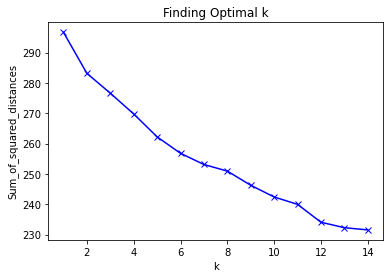

In [26]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Finding Optimal k')
plt.show()

### hence, lets pick k = 13

In [28]:
kclusters = 13
km13 = KMeans(n_clusters=kclusters)
km13 = km.fit(cities_clustering)

In [29]:
# add clustering labels to df_grouped
df_grouped.insert(0, 'Cluster Labels', km13.labels_, allow_duplicates=True)       #df_grouped is used for clustering and both have same rows
df_grouped = df_grouped.loc[:,~df_grouped.columns.duplicated()]     #remove duplicate columns
df_labelAndCity = df_grouped[['Cluster Labels', 'City']]
print('shape of df_labelAndCity', df_labelAndCity.shape)
df_labelAndCity.head()

shape of df_labelAndCity (1010, 2)


,Cluster Labels,City
0,13,"Abidjan, Côte D’Ivoire"
1,8,"Abu Dhabi, United Arab Emirates"
2,8,"Acapulco de Juárez, Mexico"
3,10,"Accra, Ghana"
4,13,"Ad Dammām, Saudi Arabia"


In [30]:
print('cities_data shape ', cities_data.shape)

cities_data shape  (1502, 3)


#### hence, there are some rows (cities present in cities_data, not in labelAndCity), hence we inner join

In [31]:
df_complete = cities_data.merge(df_labelAndCity, on='City', how='inner')
df_complete.head()

,City,lat,lng,Cluster Labels
0,"New York, United States",40.6943,-73.9249,13
1,"Mexico City, Mexico",19.4424,-99.1310,13
2,"Mumbai, India",19.0170,72.8570,2
3,"São Paulo, Brazil",-23.5587,-46.6250,11
4,"Delhi, India",28.6700,77.2300,13


## Map

In [32]:
# create map
map_clusters = folium.Map(min_zoom=2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_complete['lat'], df_complete['lng'], df_complete['City'], df_complete['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [33]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 0, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
99,"Benxi, China",Chinese Restaurant,Food,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Fondue Restaurant,Fountain
165,"Cartagena, Colombia",Chinese Restaurant,Food,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Fondue Restaurant,Fountain
190,"Chifeng, China",Chinese Restaurant,Shopping Mall,Farmers Market,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Food,Fondue Restaurant
228,"Dandong, China",Chinese Restaurant,Garden,Food,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Fondue Restaurant
271,"Farīdābād, India",Chinese Restaurant,Indian Restaurant,Fast Food Restaurant,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Food


In [34]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 1, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,"An Najaf, Iraq",Hotel,Zoo Exhibit,Food,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Fondue Restaurant
194,"Chongqing, China",Hotel,Zoo Exhibit,Food,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Fondue Restaurant
286,"Gaoping, China",Hotel,Zoo Exhibit,Food,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Fondue Restaurant
353,"Huaiyin, China",Hotel,Fast Food Restaurant,Zoo Exhibit,Food,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop
380,"Jaipur, India",Hotel,Indian Restaurant,Zoo Exhibit,Food,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Fondue Restaurant


In [35]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 2, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,"Akola, India",ATM,Café,Asian Restaurant,Dessert Shop,Indian Restaurant,Food Court,Football Stadium,Food Truck,Food Stand,Food Service
16,"Al Manşūrah, Egypt",Café,Flea Market,Train Station,Fish Taverna,Fishing Store,Fish Market,Flower Shop,Fondue Restaurant,Food,Fountain
19,"Al ‘Ayn, United Arab Emirates",Café,Gym / Fitness Center,Fast Food Restaurant,Athletics & Sports,Ice Cream Shop,Bakery,Juice Bar,Hotel,Donut Shop,Cafeteria
30,"Amman, Jordan",Café,Middle Eastern Restaurant,Bookstore,Hotel,Dessert Shop,Arts & Crafts Store,Italian Restaurant,Theater,Coffee Shop,Plaza
38,"Ansan, Korea, South",Intersection,Café,Zoo Exhibit,Food Court,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food & Drink Shop


In [36]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 3, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
419,"Kansas City, United States",Food Service,Zoo Exhibit,Food & Drink Shop,Forest,Football Stadium,Food Truck,Food Stand,Food Court,Food,Franconian Restaurant
889,"Trichinopoly, India",Food Service,Zoo Exhibit,Food & Drink Shop,Forest,Football Stadium,Food Truck,Food Stand,Food Court,Food,Franconian Restaurant


In [37]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 4, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
264,"Enugu, Nigeria",Fast Food Restaurant,Food & Drink Shop,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food,Franconian Restaurant
287,"Garoua, Cameroon",Fast Food Restaurant,Food & Drink Shop,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food,Franconian Restaurant
310,"Guatemala City, Guatemala",Fast Food Restaurant,Bus Station,Automotive Shop,Food & Drink Shop,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court
398,"Jingling, China",Fast Food Restaurant,Food & Drink Shop,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food,Franconian Restaurant
486,"Lilongwe, Malawi",Fast Food Restaurant,Food & Drink Shop,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food,Franconian Restaurant


In [38]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 5, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,"Alexandria, Egypt",Park,Middle Eastern Restaurant,Pizza Place,Cosmetics Shop,Fish Taverna,Fish Market,Fishing Store,Flea Market,Flower Shop,Fountain
60,"Az Zarqā’, Jordan",Park,Food & Drink Shop,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food,Franconian Restaurant
76,"Baotou, China",Park,Food & Drink Shop,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food,Franconian Restaurant
147,"Bytom, Poland",Park,Pool,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Zoo Exhibit
174,"Changde, China",Park,Pier,Cosmetics Shop,Fish Market,Fish Taverna,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Fountain


In [39]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 6, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Addis Ababa, Ethiopia",Restaurant,Hotel Bar,Zoo Exhibit,Fondue Restaurant,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Food
18,"Al Ḩillah, Iraq",ATM,Restaurant,Food,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Fondue Restaurant
66,"Balikpapan, Indonesia",Food,Restaurant,Zoo Exhibit,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Fondue Restaurant
152,"Calgary, Canada",Restaurant,Zoo Exhibit,Food,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Fondue Restaurant
189,"Chiclayo, Peru",Restaurant,Juice Bar,Plaza,Zoo Exhibit,Fondue Restaurant,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop


In [40]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 7, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,"As Sulaymānīyah, Iraq",Shopping Mall,Coffee Shop,Café,Fast Food Restaurant,Hotel,Asian Restaurant,Market,Turkish Restaurant,Middle Eastern Restaurant,Fish Taverna
78,"Bareilly, India",Indian Restaurant,Shopping Mall,Zoo Exhibit,Football Stadium,Food Stand,Food Service,Food Court,Food & Drink Shop,Food,Fondue Restaurant
135,"Bucaramanga, Colombia",Seafood Restaurant,BBQ Joint,Shopping Mall,Latin American Restaurant,Fast Food Restaurant,South American Restaurant,Fish Taverna,Fishing Store,Fish Market,Flea Market
176,"Changsha, China",Coffee Shop,Shopping Mall,Chinese Restaurant,Multiplex,Metro Station,Department Store,Hotel,Clothing Store,Food,Food Service
269,"Faisalabad, Pakistan",Fast Food Restaurant,Park,Asian Restaurant,Shopping Mall,Food & Drink Shop,Food Truck,Food Stand,Food Service,Food Court,Zoo Exhibit


In [41]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 8, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Abu Dhabi, United Arab Emirates",Convenience Store,Hot Spring,Hotel,French Restaurant,Coffee Shop,Medical Center,Café,Cafeteria,Zoo Exhibit,Food Service
2,"Acapulco de Juárez, Mexico",Scenic Lookout,Convenience Store,Mexican Restaurant,Bar,Theater,Plaza,Sports Bar,Fishing Store,Flea Market,Flower Shop
54,"Atlanta, United States",Liquor Store,Gas Station,Pool,Convenience Store,Park,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food
70,"Banda Aceh, Indonesia",Noodle House,Park,Indonesian Meatball Place,Breakfast Spot,Convenience Store,Electronics Store,Thai Restaurant,Café,History Museum,Department Store
124,"Brazzaville, Congo (Brazzaville)",Diner,Zoo Exhibit,Franconian Restaurant,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop


In [42]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 9, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"Ahmadābād, India",Hotel,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Historic Site,Tea Room,Zoo Exhibit,Flower Shop,Food Court,Food & Drink Shop
12,"Ajmer, India",Recreation Center,Hotel,Electronics Store,Thrift / Vintage Store,Food & Drink Shop,Football Stadium,Food Truck,Food Stand,Food Service,Food Court
24,"Algiers, Algeria",Hotel,French Restaurant,African Restaurant,Pizza Place,History Museum,Plaza,Zoo Exhibit,Food,Food Stand,Food Service
27,"Almaty, Kazakhstan",Hotel,Electronics Store,Athletics & Sports,Neighborhood,Zoo Exhibit,Food & Drink Shop,Food Truck,Food Stand,Food Service,Food Court
31,"Amritsar, India",Fast Food Restaurant,Snack Place,Hotel,Pizza Place,Fondue Restaurant,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop


In [43]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 10, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Accra, Ghana",Bus Station,Franconian Restaurant,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Zoo Exhibit
69,"Bamenda, Cameroon",Bus Station,Mobile Phone Shop,Food,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Zoo Exhibit
111,"Bogotá, Colombia",Bus Station,Museum,Food & Drink Shop,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Zoo Exhibit
360,"Ibadan, Nigeria",Bus Station,Franconian Restaurant,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Zoo Exhibit
712,"Qiqihar, China",Bus Station,Franconian Restaurant,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Zoo Exhibit


In [44]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 11, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
72,"Bandung, Indonesia",Dog Run,Snack Place,Department Store,Zoo Exhibit,Food,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop
74,"Banjarmasin, Indonesia",Bakery,Diner,Indonesian Restaurant,Food Court,Football Stadium,Food Truck,Food Stand,Food Service,Food & Drink Shop,Food
90,"Bellary, India",Pharmacy,Gym,Zoo Exhibit,Food & Drink Shop,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food
94,"Bengalūru, India",Clothing Store,Zoo Exhibit,Food,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Fondue Restaurant
102,"Bhopal, India",Clothing Store,Zoo Exhibit,Food,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Fondue Restaurant


In [45]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 12, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
223,"Dakar, Senegal",Ice Cream Shop,Zoo Exhibit,Fast Food Restaurant,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Food
354,"Huancayo, Peru",Tennis Court,Construction & Landscaping,Zoo Exhibit,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop
588,"Murrieta, United States",Construction & Landscaping,Ice Cream Shop,Zoo Exhibit,Food & Drink Shop,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food
820,"Southend-on-Sea, United Kingdom",Construction & Landscaping,Zoo Exhibit,Fountain,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop,Food
887,"Toulouse, France",Indie Theater,Construction & Landscaping,Zoo Exhibit,Food & Drink Shop,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food


In [46]:
df_result = df_labelAndCity.merge(cities_venues_sorted, how='inner')
df_result.loc[df_result['Cluster Labels'] == 13, df_result.columns[[1] + list(range(2, df_result.shape[1]))]].head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abidjan, Côte D’Ivoire",Boat or Ferry,Zoo Exhibit,Franconian Restaurant,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food & Drink Shop
4,"Ad Dammām, Saudi Arabia",Hotel,Middle Eastern Restaurant,Shopping Mall,Coffee Shop,Hookah Bar,Donut Shop,Market,Auto Garage,Asian Restaurant,Park
5,"Adana, Turkey",Kebab Restaurant,Hotel,Café,Clothing Store,Bakery,Grocery Store,Department Store,Bar,Lounge,Hotel Bar
7,"Adelaide, Australia",Pub,Garden,Dessert Shop,Italian Restaurant,Café,Grocery Store,Greek Restaurant,Convention Center,Tram Station,Wine Bar
8,"Ado-Ekiti, Nigeria",Grocery Store,Zoo Exhibit,Food & Drink Shop,Forest,Football Stadium,Food Truck,Food Stand,Food Service,Food Court,Food
